<a href="https://colab.research.google.com/github/carolinedalcomuni/tm/blob/main/Desafio3_APVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **APVC** _Desafio 3 - Grupo 21: Beatriz Maria Moura Vaz Lopes, Carolina Martins Rosa, Caroline Dalcomuni de Moura

In [1]:
# imports necessários

import os
import zipfile

import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Desafio 3

Mounted at /content/drive
/content/drive/MyDrive/Desafio 3


In [3]:
# Caminho para o arquivo zipado
zip_file_path = 'cats_and_dogs.zip'
# Diretório de destino para a extração
extracted_dir_path = 'cats_and_dogs'

# Extrair o conteúdo do arquivo zipado
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Verificar se a extração foi bem-sucedida
if os.path.exists(extracted_dir_path + '/cats_and_dogs'):
    print("Extração concluída com sucesso!")
else:
    print("Erro ao extrair o arquivo. Verifique o caminho do arquivo zipado.")

Extração concluída com sucesso!


In [14]:
# Obtenha o caminho absoluto para o diretório atual
current_dir = os.path.abspath('cats_and_dogs')

# Caminho para o diretório 'cats_and_dogs'
os.path.join(current_dir, 'cats_and_dogs/')

'/content/drive/MyDrive/Desafio 3/cats_and_dogs/cats_and_dogs/'

In [19]:
# Obtenha o caminho absoluto para o diretório atual
current_dir = os.path.abspath('cats_and_dogs')

# Caminho para o diretório 'cats_and_dogs'
cats_and_dogs_dir = os.path.join(current_dir, 'cats_and_dogs/')

# Verifique se o diretório 'cats_and_dogs/train' existe
train_dir = os.path.join(cats_and_dogs_dir, 'train')
if not os.path.exists(train_dir):
    print("Erro: Diretório 'train' não encontrado.")
else:
    print("Diretório 'train' encontrado.")

# Se 'train_dir' não for encontrado, verifique o caminho para o diretório 'cats_and_dogs' e certifique-se de que o arquivo zip foi extraído corretamente.


Diretório 'train' encontrado.


**Parte 1** - Preparação dos dados

In [43]:
# Constantes
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128

DATASET_TRAIN_PATH = cats_and_dogs_dir + "/train"  # ajustar consoante a localizacao
DATASET_VAL_PATH = cats_and_dogs_dir + "/validation"  # ajustar consoante a localizacao
SEED = 1235 # semente do gerador de numeros aleotorios que faz o split treino/validacao
VAL_TEST_SPLIT = 0.5  # fracao de imagens para o conjunto de validacao
NUM_CLASSES = 2

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_TRAIN_PATH,
  labels='inferred',
  label_mode='binary',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_VAL_PATH,
  labels='inferred',
  label_mode='binary',
  validation_split=VAL_TEST_SPLIT,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_VAL_PATH,
  labels='inferred',
  label_mode='binary',
  validation_split=VAL_TEST_SPLIT,
  subset="validation",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Using 500 files for training.
Found 1000 files belonging to 2 classes.
Using 500 files for validation.


In [44]:
# Initialize counters
count_cats_val = count_dogs_val = count_cats_test = count_dogs_test = 0

# Count classes in validation set
for _, label in val_ds:
    count_cats_val += tf.reduce_sum(tf.cast(label == 0, tf.int32))
    count_dogs_val += tf.reduce_sum(tf.cast(label == 1, tf.int32))

# Count classes in test set
for _, label in test_ds:
    count_cats_test += tf.reduce_sum(tf.cast(label == 0, tf.int32))
    count_dogs_test += tf.reduce_sum(tf.cast(label == 1, tf.int32))

# Display results
print("Class distribution in the validation set:")
print(f"Number of cats: {count_cats_val.numpy()}, Number of dogs: {count_dogs_val.numpy()}")
print("Class distribution in the test set:")
print(f"Number of cats: {count_cats_test.numpy()}, Number of dogs: {count_dogs_test.numpy()}")


Class distribution in the validation set:
Number of cats: 252, Number of dogs: 248
Class distribution in the test set:
Number of cats: 248, Number of dogs: 252


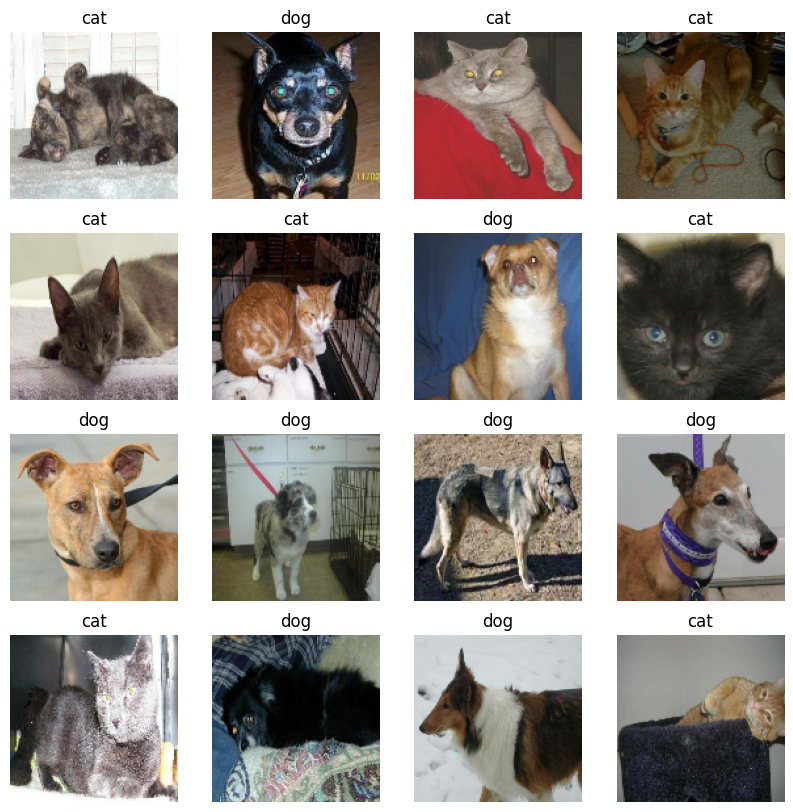

In [45]:
labels = ['cat', 'dog']

plt.figure(figsize=(10, 10))
for x_batch, y_batch in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(x_batch[i].numpy().astype("uint8"))
        plt.title(labels[int(y_batch[i])])
        plt.axis("off")
plt.show()

**Parte 2** – Rede neuronal convolucional “custom”

In [46]:
# Callbacks para guardar modelo com mais acertos e
# para terminar treino se não houver melhorias na loss

BEST_MODEL_CHECKPOINT = tf.keras.callbacks.ModelCheckpoint(
    filepath="tmp/best_model_dogs_and_cats.weights.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [55]:
# Definição da arquitetura da CNN

model = tf.keras.models.Sequential([
    layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),

    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with binary_crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 64)       

In [ ]:
# Treino do modelo
EPOCHS = 30
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[EARLY_STOPPING, BEST_MODEL_CHECKPOINT])

# Carregar o melhor modelo encontrado durante o treino
model.load_weights("tmp/best_model_dogs_and_cats.weights.h5")

In [57]:
# Obter as previsões do modelo
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obter os rótulos reais
y_true = tf.concat([y for _, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Calcular a precisão
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calcular o número de amostras classificadas incorretamente
misses = np.count_nonzero(y_true_classes - y_pred_classes)
nTestSamples = y_true_classes.shape[0]

print("Falhou em {:d} amostras num total de {:d} imagens de cães/gatos".format(misses, nTestSamples))
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))

8/8 [==============================] - 4s 304ms/step
Falhou em 0 amostras num total de 500 imagens de cães/gatos
Taxa de acertos: 100.00 %


In [ ]:
# Calcular accuracy manualmente

correct_predictions = np.sum(y_true_classes == y_pred_classes)
total_samples = len(y_true_classes)
accuracy_manual = correct_predictions / total_samples

print("Correct Predictions:", correct_predictions)
print("Total Samples:", total_samples)
print("Manual Accuracy: {:.2f}%".format(accuracy_manual * 100))


In [ ]:
# Cálculo da matriz de confusão
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Não era isto que estava a esperaaaaaaaaaa !!! :(

In [ ]:
# Gráficos de evolução da loss e acertos
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

**Parte 3** – Transferência de conhecimento
